<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBindAdvancedProteinEmbeddingWMorganFingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Pre-install working scikit-learn to stop PyTDC backtracking
!pip install scikit-learn==1.3.2

# 2. Install PyTDC but skip its dependency re-resolution
!pip install PyTDC==1.1.15 --no-deps

# 3. Core scientific libraries
!pip install pandas tqdm deepchem

# 4. RDKit from official wheels (chemistry toolkit)
!pip install rdkit==2023.9.1 -f https://wheels.rdkit.org

# 5. Torch stack (CPU-safe versions)
!pip install torch==2.1.0 torchvision torchaudio

# 6. Torch Geometric (must match Torch version)
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 40.8 MB/s eta 0:00:00
Looking in links: https://wheels.rdkit.org
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytdc 1.1.15 requires cellxgene-census==1.15.0, which is not installed.
pytdc 1.1.15 requires dataclasses<1.0,>=0.6, which is not installed.
pytdc 1.1.15 requires evaluate==0.4.2, which is not installed.
pytdc 1.1.15 requires fuzzywuzzy<1.0,>=0.18.0, which is not installed.
pytdc 1.1.15 requires gget<1.0.0,>=0.28.4, which is not installed.
pytdc 1.1.15 requires tiledbsoma<2.0.0,>=1.7.2, which is not installed.
pytdc 1.1.15 requires accelerate==0.33.0, but you have accelerate 1.10.1 which is incompatible.
pytdc 1.1.15 requires datasets<2.20.0, but you have datasets 4.0.0 which is incompatible.
pytdc 1.1.15 requires r

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# This will give better error messages

In [3]:
!pip install fair-esm biopython torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 111.5 MB/s eta 0:00:00


In [4]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

In [5]:
# Load data set
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [ ]:
# Grab tester path files
iterator = 0
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Features (X):", X)
    print()
    print(X[0][1])
    print("Label (y):", y)
    print("Weight (w):", w)
    print("ID:", ids)
    iterator += 1
    if iterator == 2:
      break  # Just show the first one

Features (X): [['/tmp/refined-set/1eoc/1eoc_ligand.sdf'
  '/tmp/refined-set/1eoc/1eoc_pocket.pdb']]

/tmp/refined-set/1eoc/1eoc_pocket.pdb
Label (y): [-0.18912133]
Weight (w): [1.]
ID: ['1eoc']
Features (X): [['/tmp/refined-set/4f0c/4f0c_ligand.sdf'
  '/tmp/refined-set/4f0c/4f0c_pocket.pdb']]

/tmp/refined-set/4f0c/4f0c_pocket.pdb
Label (y): [-0.07805682]
Weight (w): [1.]
ID: ['4f0c']


**Preprocessing Functions**

Drug Preprocessing Functions

In [6]:
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data

def get_node_features(mol):
    all_node_feats = []
    for atom in mol.GetAtoms():
        node_feats = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),  # convert enum to int
            atom.GetIsAromatic(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.IsInRing(),
            int(atom.GetChiralTag())  # convert enum to int
        ]
        all_node_feats.append(node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(),
            bond.IsInRing()
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Bidirectional edges
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

In [7]:
from rdkit.Chem import AllChem

def get_morgan_fingerprint(mol, radius=2, n_bits=1024):
    """Generate Morgan fingerprint (ECFP) for a molecule."""
    if mol is None:
        return torch.zeros(n_bits, dtype=torch.float32)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return torch.tensor(list(fp), dtype=torch.float32)


Protein Preprocessing Functions

In [8]:
# STEP 1: Extract Protein Sequence from PDB (pocket.pdb) File
from Bio import PDB

def extract_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from the associated protein PDB file using Biopython."""

    # Replace 'pocket' with 'protein' in the provided path
    protein_path = pdb_path.replace("pocket", "protein")

    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("full_protein", protein_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

In [9]:
# STEP 2: Extract Pocket Sequence from PDB (pocket.pdb) FIle
def extract_pocket_from_pdb(pdb_path):
    "Extracts the amino pocket amino acid sequence from a PDB file using Biopython"
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("pocket_only", pdb_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

In [10]:
# STEP 3: Generate ESM-2 Embedddings
# Outputs dense embeddings for each residue reflecting biochemical knolwedge learned from massive sequence databases such as:
# Motifs, functional sites, long-range dependencies, evolutionarly relationships
# This uses a richer protein representation through a pretrained protein language model

import torch
import esm

# Load ESM-2 pretrained model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # loads ESM-2 model, defines how amino acids are tokenized
batch_converter = alphabet.get_batch_converter() # creates a function to convert sequences into tokenized tensors
model.eval()  # Disable dropout, puts the model in evaluation mode

def embed_sequence(seq):
    batch_labels, batch_strs, batch_tokens = batch_converter([("protein", seq)])
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=False)
    # Use mean over all residues (excluding padding and BOS/EOS)
    token_representations = results["representations"][6]
    embedding = token_representations[0, 1:len(seq)+1].mean(0) # outputs a single vector representing the whole protein using pretrained 33rd final layer
    return embedding  # shape: (320,) - 1D tensor with 1280 values, one for each learned feature in final transformer layer

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [11]:
# STEP 4: Generate a combined embedding of the concatenated protein and binding site from the PLM

def generate_combined_embedding(pdb_path):
    full_seq = extract_sequence_from_pdb(pdb_path)
    pocket_seq = extract_pocket_from_pdb(pdb_path)

    full_emb = embed_sequence(full_seq)
    pocket_emb = embed_sequence(pocket_seq)

    combined = torch.cat([full_emb, pocket_emb], dim=0)  # shape: (640,)

    # print("Protein Sequence: ", full_seq)
    # print("Pocket Sequence: ", pocket_seq)
    # print(combined)

    return combined

In [12]:
# Function tester
example_protein_path = "/tmp/refined-set/5fnu/5fnu_pocket.pdb"

combined = generate_combined_embedding(example_protein_path)

**Preprocessing the Data Sets**

In [13]:
def process_deepchem_dataset(dc_dataset):
    molecule_data = []

    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        protein_path = X[0][1]

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))
        if ligand_mol is None:
            print(f"Failed to load ligand molecule from {ligand_path}")
            continue

        # --- Atom & bond graph features ---
        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)

        # --- NEW: Morgan fingerprint ---
        smiles = Chem.MolToSmiles(ligand_mol)
        morgan_fp = get_morgan_fingerprint(ligand_mol, radius=2, n_bits=1024)

        # --- Protein embeddings ---
        target_features = generate_combined_embedding(protein_path)
        target_features = target_features.unsqueeze(0)  # (1, 640)

        # --- Package sample ---
        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features
        data.morgan_fp = morgan_fp.unsqueeze(0)  ### NEW

        molecule_data.append(data)

    return molecule_data


In [14]:
# Embed each dataset with preprocessing algorithms
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

# Create DataLoaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

[17:08:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:51] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:08:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6euw/6euw_ligand.sdf


[17:08:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:51] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:08:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5efc/5efc_ligand.sdf


[17:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:53] Explicit valence for atom # 61 C, 6, is greater than permitted
[17:08:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:53] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:08:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:53] Explicit valence for atom # 12 C, 6, is greater than permi

Failed to load ligand molecule from /tmp/refined-set/1fzk/1fzk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ge7/3ge7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3rdq/3rdq_ligand.sdf


[17:08:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:54] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4x5p/4x5p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4g8m/4g8m_ligand.sdf


[17:08:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3k37/3k37_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5l9i/5l9i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5dyo/5dyo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2olb/2olb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ysl/4ysl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3w9r/3w9r_ligand.sdf


[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:08:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:55] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/3tf6/3tf6_ligand.sdf


[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4nwc/4nwc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ej8/4ej8_ligand.sdf


[17:08:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:57] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:08:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pin/4pin_ligand.sdf


[17:08:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:08:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:58] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:08:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:58] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:08:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4gzp/4gzp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2rcn/2rcn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1sqo/1sqo_ligand.sdf


[17:08:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:08:59] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:08:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qps/3qps_ligand.sdf


[17:09:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4o61/4o61_ligand.sdf


[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:09] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:09] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:09:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cjp/4cjp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1swr/1swr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2wky/2wky_ligand.sdf


[17:09:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:11] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3daz/3daz_ligand.sdf


[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1lah/1lah_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zqe/3zqe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1mfi/1mfi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3m8u/3m8u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5btv/5btv_ligand.sdf


[17:09:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:13] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4qxo/4qxo_ligand.sdf


[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:15] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/3nq3/3nq3_ligand.sdf


[17:09:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:16] Explicit valence for atom # 28 C, 6, is greater than permitted
[17:09:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6f1n/6f1n_ligand.sdf


[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:17] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:17] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1sqt/1sqt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3f8e/3f8e_ligand.sdf


[17:09:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Explicit valence fo

Failed to load ligand molecule from /tmp/refined-set/5fh7/5fh7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3h78/3h78_ligand.sdf


[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:22] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:09:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5u13/5u13_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5b2d/5b2d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4f7v/4f7v_ligand.sdf


[17:09:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:24] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:24] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:24] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ew2/4ew2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5l9g/5l9g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cj4/4cj4_ligand.sdf


[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ivv/5ivv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ddm/4ddm_ligand.sdf


[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5hz8/5hz8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2dw7/2dw7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hyo/1hyo_ligand.sdf


[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:09:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5jhk/5jhk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pwk/3pwk_ligand.sdf


[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:43] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:43] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b1h/1b1h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3n86/3n86_ligand.sdf


[17:09:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:44] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:09:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:09:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2r5a/2r5a_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2x96/2x96_ligand.sdf


[17:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:09:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3n8k/3n8k_ligand.sdf


[17:09:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:09:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:12] Explicit valence for atom # 1 S, 7, is greater than permitted
[17:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:12] Explicit valence for atom # 43 C, 6, is greater than permitted
[17:10:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4nj9/4nj9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3p9m/3p9m_ligand.sdf


[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4erf/4erf_ligand.sdf


[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2pbw/2pbw_ligand.sdf


[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:14] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:10:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2p4y/2p4y_ligand.sdf


[17:10:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/6eux/6eux_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5u4d/5u4d_ligand.sdf


[17:10:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:24] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:10:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2fzk/2fzk_ligand.sdf


[17:10:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:26] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:10:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5boj/5boj_ligand.sdf


[17:10:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:27] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:10:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:27] Explicit valence for atom # 33 C, 6, is greater than permitted
[17:10:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qb6/1qb6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6q3q/6q3q_ligand.sdf


[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4daf/4daf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2fqt/2fqt_ligand.sdf


[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5fnt/5fnt_ligand.sdf


[17:10:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2f7i/2f7i_ligand.sdf


[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5org/5org_ligand.sdf


[17:10:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:45] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:10:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1t5f/1t5f_ligand.sdf


[17:10:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:10:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3u6h/3u6h_ligand.sdf


[17:10:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:47] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:10:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ypo/2ypo_ligand.sdf


[17:10:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:49] Explicit valence for atom # 1 S, 7, is greater than permitted
[17:10:49] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/5cs3/5cs3_ligand.sdf


[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:50] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:10:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/4yha/4yha_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ypg/1ypg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cg9/4cg9_ligand.sdf


[17:10:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1w13/1w13_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gss/3gss_ligand.sdf


[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 39 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4gql/4gql_ligand.sdf


[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4o3c/4o3c_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hww/3hww_ligand.sdf


[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:54] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:10:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p3s/3p3s_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2nsj/2nsj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zxg/2zxg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5v7a/5v7a_ligand.sdf


[17:10:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:58] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:10:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bok/2bok_ligand.sdf


[17:10:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:59] Explicit valence for atom # 0 S, 7, is greater than permitted
[17:10:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:10:59] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:10:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fxp/4fxp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zdk/2zdk_ligand.sdf


[17:11:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:01] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1y0l/1y0l_ligand.sdf


[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:01] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:11:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nw7/1nw7_ligand.sdf


[17:11:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4db7/4db7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5evb/5evb_ligand.sdf


[17:11:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Explicit valence for atom # 36 C, 6, is greater than permitted
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f4e/1f4e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tsk/3tsk_ligand.sdf


[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3pce/3pce_ligand.sdf


[17:11:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5zc5/5zc5_ligand.sdf


[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Explicit valence for atom # 25 S, 7, is greater than permitted
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:09] Explicit valence for atom # 31 S, 7, is greater than permitted
[17:11:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3l4x/3l4x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5yhe/5yhe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3qqa/3qqa_ligand.sdf


[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5y13/5y13_ligand.sdf


[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f57/1f57_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3lmk/3lmk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5y12/5y12_ligand.sdf


[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:11] Explicit valence for atom # 33 C, 6, is greater than permitted
[17:11:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5e3a/5e3a_ligand.sdf


[17:11:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:11:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:13] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:11:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3pd9/3pd9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2d3z/2d3z_ligand.sdf


[17:11:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:14] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:11:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3hk1/3hk1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ezz/4ezz_ligand.sdf


[17:11:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ceb/4ceb_ligand.sdf


[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:16] Explicit valence for atom # 39 C, 6, is greater than permitted
[17:11:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3iss/3iss_ligand.sdf


[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4myd/4myd_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1xhy/1xhy_ligand.sdf


[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coo

Failed to load ligand molecule from /tmp/refined-set/2zdl/2zdl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2v8w/2v8w_ligand.sdf


[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Explicit valence for atom # 61 C, 6, is greater than permitted
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pg9/4pg9_ligand.sdf


[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:18] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pp0/4pp0_ligand.sdf


[17:11:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/4kwo/4kwo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gx0/3gx0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5jsq/5jsq_ligand.sdf


[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:20] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:11:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5kva/5kva_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4gzx/4gzx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zsq/3zsq_ligand.sdf


[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:21] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:21] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4yc0/4yc0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pfp/3pfp_ligand.sdf


[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:21] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:11:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1td7/1td7_ligand.sdf


[17:11:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:24] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:11:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:24] Explicit valence for atom # 5 C, 5, is greater than permitted
[17:11:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f5l/1f5l_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5u0y/5u0y_ligand.sdf


[17:11:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:25] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:11:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:25] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:11:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2wr8/2wr8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1srg/1srg_ligand.sdf


[17:11:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:26] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:11:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ivy/5ivy_ligand.sdf


[17:11:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5e2l/5e2l_ligand.sdf


[17:11:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1fiv/1fiv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kn0/4kn0_ligand.sdf


[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6b4l/6b4l_ligand.sdf


[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ngn/4ngn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3f3d/3f3d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5d47/5d47_ligand.sdf


[17:11:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4ipi/4ipi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ai5/1ai5_ligand.sdf


[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:11:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cga/4cga_ligand.sdf


[17:11:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:34] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:11:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3l59/3l59_ligand.sdf


[17:11:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:34] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:11:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bgz/3bgz_ligand.sdf


[17:11:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:37] Explicit valence for atom # 62 C, 6, is greater than permitted
[17:11:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5isz/5isz_ligand.sdf


[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:38] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5hi7/5hi7_ligand.sdf


[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 50 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/6evn/6evn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ito/5ito_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1cps/1cps_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1g74/1g74_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kz6/4kz6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ciz/1ciz_ligand.sdf


[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/2rk8/2rk8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5m23/5m23_ligand.sdf


[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4tkb/4tkb_ligand.sdf


[17:11:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4y3j/4y3j_ligand.sdf


[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1cgl/1cgl_ligand.sdf


[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1xbo/1xbo_ligand.sdf


[17:11:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:44] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:11:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/4rd3/4rd3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nz4/5nz4_ligand.sdf


[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lbf/1lbf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2i4z/2i4z_ligand.sdf


[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for atom # 32 C, 6, is greater than permitted
[17:11:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:45] Explicit valence for at

Failed to load ligand molecule from /tmp/refined-set/2jgs/2jgs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4k5p/4k5p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ajq/1ajq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4tmn/4tmn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6d50/6d50_ligand.sdf


[17:11:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:46] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:11:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:46] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:11:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bz6/2bz6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f4g/1f4g_ligand.sdf


[17:11:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3f3c/3f3c_ligand.sdf


[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:53] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:11:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1pz5/1pz5_ligand.sdf


[17:11:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4hfp/4hfp_ligand.sdf


[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Explicit valence for atom # 31 C, 6, is greater than permitted
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nw3/3nw3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ge7/6ge7_ligand.sdf


[17:11:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1wn6/1wn6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f4f/1f4f_ligand.sdf


[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:58] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3vje/3vje_ligand.sdf


[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:58] Explicit valence for atom # 45 N, 4, is greater than permitted
[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3agl/3agl_ligand.sdf


[17:11:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:11:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:11:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qrl/2qrl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pgu/3pgu_ligand.sdf


[17:12:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:00] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:12:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bfu/3bfu_ligand.sdf


[17:12:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1sv3/1sv3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vj8/2vj8_ligand.sdf


[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:13] Explicit valence for atom # 38 C, 6, is greater than permitted
[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fch/1fch_ligand.sdf


[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:13] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:13] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6b4u/6b4u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6fnq/6fnq_ligand.sdf


[17:12:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:14] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:12:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2h6b/2h6b_ligand.sdf


[17:12:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:15] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:12:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dhl/4dhl_ligand.sdf


[17:12:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:12:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:24] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:24] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4tjz/4tjz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hdq/1hdq_ligand.sdf


[17:12:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:25] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:12:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6ma3/6ma3_ligand.sdf


[17:12:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:12:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ctc/2ctc_ligand.sdf


[17:12:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:27] Explicit valence for atom # 36 C, 6, is greater than permitted
[17:12:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4l6t/4l6t_ligand.sdf


[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4f0c/4f0c_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1oss/1oss_ligand.sdf


[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:33] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:12:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6g9u/6g9u_ligand.sdf


[17:12:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:34] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:12:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:12:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cjq/4cjq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o2h/1o2h_ligand.sdf


[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:35] Explicit valence for at

Failed to load ligand molecule from /tmp/refined-set/1d4p/1d4p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ghh/6ghh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nq7/1nq7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4oc5/4oc5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4d8z/4d8z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3lp7/3lp7_ligand.sdf


[17:12:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3pe1/3pe1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ceb/1ceb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5gs9/5gs9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1z9y/1z9y_ligand.sdf


[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:37] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3iqu/3iqu_ligand.sdf


[17:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4uma/4uma_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3rdo/3rdo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1g98/1g98_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3neo/3neo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lag/1lag_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2nn1/2nn1_ligand.sdf


[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gvz/6gvz_ligand.sdf


[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordina

Failed to load ligand molecule from /tmp/refined-set/3kek/3kek_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4io6/4io6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5oei/5oei_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ulp/5ulp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hfs/1hfs_ligand.sdf


[17:12:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ovv/5ovv_ligand.sdf


[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gyy/1gyy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4fht/4fht_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ajp/1ajp_ligand.sdf


[17:12:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3cd7/3cd7_ligand.sdf


[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5lif/5lif_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4oc0/4oc0_ligand.sdf


[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:51] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:12:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fs4/4fs4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6fmc/6fmc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4i8n/4i8n_ligand.sdf


[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:53] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/4bqs/4bqs_ligand.sdf


[17:12:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:54] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:12:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:54] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:12:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kx8/4kx8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4iuo/4iuo_ligand.sdf


[17:12:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:55] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:12:55] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/6f05/6f05_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o2n/1o2n_ligand.sdf


[17:12:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:57] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:57] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5wp5/5wp5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b6h/1b6h_ligand.sdf


[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:57] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:57] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:12:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1xug/1xug_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ahs/4ahs_ligand.sdf


[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zda/2zda_ligand.sdf


[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o3j/1o3j_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3n76/3n76_ligand.sdf


[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2w/1v2w_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5hz6/5hz6_ligand.sdf


[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:12:59] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:12:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5kab/5kab_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4igt/4igt_ligand.sdf


[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2fw6/2fw6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1p1n/1p1n_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vwm/2vwm_ligand.sdf


[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2b9a/2b9a_ligand.sdf


[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:00] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:13:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6cwn/6cwn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5hbn/5hbn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1g7g/1g7g_ligand.sdf


[17:13:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:01] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:13:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3h8b/3h8b_ligand.sdf


[17:13:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:02] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:13:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ovg/4ovg_ligand.sdf


[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Explicit valence for atom # 31 C, 6, is greater than permitted
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ibk/4ibk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qbp/2qbp_ligand.sdf


[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4exs/4exs_ligand.sdf


[17:13:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:13:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:05] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:13:05] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4zb8/4zb8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4omc/4omc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5neb/5neb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1y1z/1y1z_ligand.sdf


[17:13:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o3f/1o3f_ligand.sdf


[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:06] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:13:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1oau/1oau_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1jq8/1jq8_ligand.sdf


[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5fnr/5fnr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gc4/3gc4_ligand.sdf


[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qwe/2qwe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ce6/6ce6_ligand.sdf


[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4a4w/4a4w_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ols/1ols_ligand.sdf


[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:13:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:09] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/5bv3/5bv3_ligand.sdf


[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1k21/1k21_ligand.sdf


[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4eb8/4eb8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4gzt/4gzt_ligand.sdf


[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:11] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ncn/4ncn_ligand.sdf


[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:13] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:13:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:13] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:13:13] Warning: molecule is tagged as 2D, but at least one Z coo

Failed to load ligand molecule from /tmp/refined-set/3gba/3gba_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ljo/3ljo_ligand.sdf


[17:13:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:35] Explicit valence for atom # 49 N, 4, is greater than permitted
[17:13:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:35] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:13:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ag9/3ag9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4tu4/4tu4_ligand.sdf


[17:13:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:53] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:13:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c1v/1c1v_ligand.sdf


[17:13:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:55] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:13:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6ghj/6ghj_ligand.sdf


[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2h4g/2h4g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4baq/4baq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4je8/4je8_ligand.sdf


[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Explicit valence for atom # 34 C, 6, is greater than permitted
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3cd0/3cd0_ligand.sdf


[17:13:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:13:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5otc/5otc_ligand.sdf


[17:13:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:57] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:13:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2al5/2al5_ligand.sdf


[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:58] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:58] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3uxl/3uxl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qyg/1qyg_ligand.sdf


[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:13:59] Explicit valence for atom # 1 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/2d0k/2d0k_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1p1q/1p1q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nkd/5nkd_ligand.sdf


[17:13:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:00] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:14:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4sga/4sga_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uri/3uri_ligand.sdf


[17:14:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:01] Explicit valence for atom # 56 C, 6, is greater than permitted
[17:14:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:02] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5za8/5za8_ligand.sdf


[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ngm/4ngm_ligand.sdf


[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:02] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:14:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3liw/3liw_ligand.sdf


[17:14:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:03] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:14:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:14:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ryd/4ryd_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fed/3fed_ligand.sdf


[17:14:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:04] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/4tim/4tim_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ewa/5ewa_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qan/1qan_ligand.sdf


[17:14:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:05] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:14:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2v2c/2v2c_ligand.sdf


[17:14:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:06] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:14:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nny/1nny_ligand.sdf


[17:14:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:07] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:14:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ibb/4ibb_ligand.sdf


[17:14:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:08] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/4tkj/4tkj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nwl/1nwl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b7h/1b7h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5efa/5efa_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b3h/1b3h_ligand.sdf


[17:14:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:10] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/3ppp/3ppp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zft/2zft_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5m04/5m04_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5etj/5etj_ligand.sdf


[17:14:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:11] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:14:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xn5/2xn5_ligand.sdf


[17:14:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4leq/4leq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o3l/1o3l_ligand.sdf


[17:14:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:35] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:14:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nik/3nik_ligand.sdf


[17:14:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:36] Explicit valence for atom # 2 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/3gvb/3gvb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3h1x/3h1x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4zv1/4zv1_ligand.sdf


[17:14:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:38] Explicit valence for atom # 50 C, 6, is greater than permitted
[17:14:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4czs/4czs_ligand.sdf


[17:14:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:38] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:14:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c84/1c84_ligand.sdf


[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:39] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b3l/1b3l_ligand.sdf


[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5j41/5j41_ligand.sdf


[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b5i/1b5i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4dsy/4dsy_ligand.sdf


[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4umc/4umc_ligand.sdf


[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:41] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:14:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4y0a/4y0a_ligand.sdf


[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:42] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:14:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lkl/1lkl_ligand.sdf


[17:14:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/2wuf/2wuf_ligand.sdf


[17:14:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:55] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:14:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xyd/2xyd_ligand.sdf


[17:14:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:14:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:57] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3fjg/3fjg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4e7r/4e7r_ligand.sdf


[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordi

Failed to load ligand molecule from /tmp/refined-set/3u92/3u92_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6eqw/6eqw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zsy/3zsy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5o1h/5o1h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uo4/3uo4_ligand.sdf


[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:14:59] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:14:59] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/1n0s/1n0s_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b8y/1b8y_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3mfw/3mfw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ppc/1ppc_ligand.sdf


[17:15:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:01] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:15:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:15:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:15:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/3b4p/3b4p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6aqs/6aqs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2ypi/2ypi_ligand.sdf


[17:15:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4efs/4efs_ligand.sdf


[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fcy/1fcy_ligand.sdf


[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:05] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6bm6/6bm6_ligand.sdf


[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 61 C, 6, is greater than permitted
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:15:06] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/2q88/2q88_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fzo/1fzo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ipj/4ipj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m8h/4m8h_ligand.sdf


[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gf9/6gf9_ligand.sdf


[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:06] Explicit valence for atom # 43 N, 4, is greater than permitted
[17:15:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3utu/3utu_ligand.sdf


[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/2v77/2v77_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4k6i/4k6i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2v25/2v25_ligand.sdf


[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fvn/3fvn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3t2w/3t2w_ligand.sdf


[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6bm5/6bm5_ligand.sdf


[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bah/4bah_ligand.sdf


[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 42 C, 6, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6g98/6g98_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ovp/5ovp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ony/1ony_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4mdn/4mdn_ligand.sdf


[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v11/1v11_ligand.sdf


[17:15:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:13] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:15:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2p2a/2p2a_ligand.sdf


[17:15:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:14] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/4gq4/4gq4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3c8b/3c8b_ligand.sdf


[17:15:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:15:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5nk8/5nk8_ligand.sdf


[17:15:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:18] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5eh8/5eh8_ligand.sdf


[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3tvc/3tvc_ligand.sdf


[17:15:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:19] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:15:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:19] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:15:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dju/4dju_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qbw/2qbw_ligand.sdf


[17:15:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1d09/1d09_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3n7a/3n7a_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hee/1hee_ligand.sdf


[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:39] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:39] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ivx/3ivx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1olx/1olx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1a94/1a94_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5sxm/5sxm_ligand.sdf


[17:15:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3hf8/3hf8_ligand.sdf


[17:15:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/4ykj/4ykj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4aj4/4aj4_ligand.sdf


[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:41] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:15:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:42] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ddh/4ddh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ma7/5ma7_ligand.sdf


[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:42] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:42] Explicit valence for atom # 24 S, 7, is greater than permitted
[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:42] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:15:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1l8g/1l8g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zcr/2zcr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zmm/2zmm_ligand.sdf


[17:15:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:45] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:15:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:45] Explicit valence fo

Failed to load ligand molecule from /tmp/refined-set/4aji/4aji_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4s1g/4s1g_ligand.sdf


[17:15:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4j48/4j48_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1os0/1os0_ligand.sdf


[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dzy/4dzy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fd0/1fd0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4h81/4h81_ligand.sdf


[17:15:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:15:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lst/1lst_ligand.sdf


[17:15:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3ebh/3ebh_ligand.sdf


[17:15:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1k1i/1k1i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1s89/1s89_ligand.sdf


[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:15:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:01] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/3usx/3usx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fee/3fee_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4b6r/4b6r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1kel/1kel_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zso/3zso_ligand.sdf


[17:16:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:02] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:16:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4g0z/4g0z_ligand.sdf


[17:16:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3l3n/3l3n_ligand.sdf


[17:16:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/4b5t/4b5t_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3l4v/3l4v_ligand.sdf


[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4nyf/4nyf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1kui/1kui_ligand.sdf


[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for atom # 43 C, 6, is greater than permitted
[17:16:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3cdb/3cdb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4muf/4muf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1g7f/1g7f_ligand.sdf


[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Explicit valence for atom # 41 C, 6, is greater than permitted
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5nwi/5nwi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2rcb/2rcb_ligand.sdf


[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/2qwb/2qwb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4hw3/4hw3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c5y/1c5y_ligand.sdf


[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2u/1v2u_ligand.sdf


[17:16:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 9 S, 7, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/1m4h/1m4h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5fnu/5fnu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3cfn/3cfn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3veh/3veh_ligand.sdf


[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:13] Explicit valence for atom

Failed to load ligand molecule from /tmp/refined-set/4cpy/4cpy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bwj/3bwj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4b5s/4b5s_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5cbr/5cbr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4bcs/4bcs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b51/1b51_ligand.sdf


[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:14] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2c80/2c80_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ej2/6ej2_ligand.sdf


[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:14] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:14] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1z9g/1z9g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1v2t/1v2t_ligand.sdf


[17:16:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3uil/3uil_ligand.sdf


[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:15] Explicit valence for atom # 27 C, 5, is greater than permitted
[17:16:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ssq/1ssq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1a9m/1a9m_ligand.sdf


[17:16:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:16] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:16:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3rf5/3rf5_ligand.sdf


[17:16:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:16] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:17] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:17] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ef6/4ef6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4lbu/4lbu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4b6p/4b6p_ligand.sdf


[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:17] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2pv1/2pv1_ligand.sdf


[17:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:18] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:16:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:18] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:16:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3b7r/3b7r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5edc/5edc_ligand.sdf


[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/2pyy/2pyy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1w11/1w11_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o5a/1o5a_ligand.sdf


[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:20] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:16:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4qfl/4qfl_ligand.sdf


[17:16:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/3pcn/3pcn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hk4/1hk4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5u4b/5u4b_ligand.sdf


[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:24] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:16:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:24] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/1c5x/1c5x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6mjf/6mjf_ligand.sdf


[17:16:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/4b7r/4b7r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2x91/2x91_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2r1y/2r1y_ligand.sdf


[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1k1l/1k1l_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hp9/3hp9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3u9q/3u9q_ligand.sdf


[17:16:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:37] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:16:37] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/5ka9/5ka9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1tx7/1tx7_ligand.sdf


[17:16:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1r1j/1r1j_ligand.sdf


[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:39] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:16:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5qay/5qay_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5lsg/5lsg_ligand.sdf


[17:16:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:42] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:16:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1zdp/1zdp_ligand.sdf


[17:16:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:43] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:16:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Failed to load ligand molecule from /tmp/refined-set/4q4s/4q4s_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3cct/3cct_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3t6b/3t6b_ligand.sdf


[17:16:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:45] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:16:45] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/3rlb/3rlb_ligand.sdf


[17:16:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:16:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fzj/4fzj_ligand.sdf


[17:16:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:16:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5iyy/5iyy_ligand.sdf


[17:16:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:50] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:16:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kxb/4kxb_ligand.sdf


[17:16:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:53] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:53] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/3t01/3t01_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ibj/4ibj_ligand.sdf


[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:55] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/2qwd/2qwd_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6f9v/6f9v_ligand.sdf


[17:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:56] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:16:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5amg/5amg_ligand.sdf


[17:16:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:58] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:16:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1a4w/1a4w_ligand.sdf


[17:16:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Explicit valence for atom # 1 S, 7, is greater than permitted
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/1eb2/1eb2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1rql/1rql_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ipu/3ipu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m0r/4m0r_ligand.sdf


[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:16:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:16:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2pu2/2pu2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5bw4/5bw4_ligand.sdf


[17:17:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kif/4kif_ligand.sdf


[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3o84/3o84_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2hzy/2hzy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qpd/4qpd_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1njs/1njs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2v88/2v88_ligand.sdf


[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:06] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/2rke/2rke_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zt2/3zt2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nkc/5nkc_ligand.sdf


[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6iiu/6iiu_ligand.sdf


[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Explicit valence for atom # 34 N, 4, is greater than permitted
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:17:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bzf/3bzf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2buv/2buv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6bdy/6bdy_ligand.sdf


[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gar/1gar_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4yb5/4yb5_ligand.sdf


[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:08] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:17:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1vyg/1vyg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ymh/4ymh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qkb/1qkb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ibc/4ibc_ligand.sdf


[17:17:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:09] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:17:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bet/2bet_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1yei/1yei_ligand.sdf


[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:10] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zvi/4zvi_ligand.sdf


[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3o5x/3o5x_ligand.sdf


[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:11] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fsl/4fsl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zfs/2zfs_ligand.sdf


[17:17:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:17:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4o9v/4o9v_ligand.sdf


[17:17:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3q1x/3q1x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hmt/1hmt_ligand.sdf


[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2r9x/2r9x_ligand.sdf


[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:13] Warning: molecule is tagged as 2D, but at least one Z coordinat

Failed to load ligand molecule from /tmp/refined-set/3fx6/3fx6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o3i/1o3i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4r4c/4r4c_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nz7/1nz7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f8e/1f8e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2tpi/2tpi_ligand.sdf


[17:17:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:17:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gjc/1gjc_ligand.sdf


[17:17:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Explicit valence for atom # 53 C, 6, is greater than permitted
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1xr9/1xr9_ligand.sdf


[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:20] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:17:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zw8/4zw8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5xmx/5xmx_ligand.sdf


[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ey0/5ey0_ligand.sdf


[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:21] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nq9/3nq9_ligand.sdf


[17:17:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3po1/3po1_ligand.sdf


[17:17:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:24] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:17:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5e7n/5e7n_ligand.sdf


[17:17:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5k0h/5k0h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1jzs/1jzs_ligand.sdf


[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3mfv/3mfv_ligand.sdf


[17:17:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:27] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:17:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4euo/4euo_ligand.sdf


[17:17:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:17:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5dq8/5dq8_ligand.sdf


[17:17:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3zln/3zln_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o2z/1o2z_ligand.sdf


[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:29] Explicit valence for atom # 25 S, 7, is greater than permitted
[17:17:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3lpp/3lpp_ligand.sdf


[17:17:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:17:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:17:47] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4uc5/4uc5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4br3/4br3_ligand.sdf


[17:17:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1pgp/1pgp_ligand.sdf


[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gnw/6gnw_ligand.sdf


[17:17:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:50] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:17:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:17:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:17:50] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:17:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xj2/2xj2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hsl/1hsl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ks1/4ks1_ligand.sdf


[17:18:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:06] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:18:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4phu/4phu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ts1/4ts1_ligand.sdf


[17:18:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:10] Explicit valence for atom # 39 C, 6, is greater than permitted
[17:18:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5czm/5czm_ligand.sdf


[17:18:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:12] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4jpy/4jpy_ligand.sdf


[17:18:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:20] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:18:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c87/1c87_ligand.sdf


[17:18:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zbi/4zbi_ligand.sdf


[17:18:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ehw/5ehw_ligand.sdf


[17:18:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:28] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:18:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bmk/2bmk_ligand.sdf


[17:18:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:30] Explicit valence for atom # 23 S, 7, is greater than permitted
[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5duw/5duw_ligand.sdf


[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1i2s/1i2s_ligand.sdf


[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:30] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:18:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ad6/4ad6_ligand.sdf


[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2f35/2f35_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3cda/3cda_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1mh5/1mh5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c83/1c83_ligand.sdf


[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bvs/2bvs_ligand.sdf


[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:32] Explicit valence for atom # 9 S, 7, is greater than permitted
[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3f3e/3f3e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3cft/3cft_ligand.sdf


[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1w9v/1w9v_ligand.sdf


[17:18:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:33] Explicit valence for atom # 49 N, 4, is greater than permitted
[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2aog/2aog_ligand.sdf


[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ai4/1ai4_ligand.sdf


[17:18:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:34] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:18:34] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/1y3p/1y3p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1wuq/1wuq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o2j/1o2j_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1pa9/1pa9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2aoe/2aoe_ligand.sdf


[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:35] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:18:35] Warning: molecule is t

Failed to load ligand molecule from /tmp/refined-set/1fjs/1fjs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4or6/4or6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4avs/4avs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2r59/2r59_ligand.sdf


[17:18:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:36] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:18:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gon/6gon_ligand.sdf


[17:18:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1usi/1usi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ouj/3ouj_ligand.sdf


[17:18:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5kej/5kej_ligand.sdf


[17:18:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:18:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4xmr/4xmr_ligand.sdf


[17:18:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Explicit valence fo

Failed to load ligand molecule from /tmp/refined-set/1jcx/1jcx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ecv/1ecv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qdt/2qdt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3lp4/3lp4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4jn2/4jn2_ligand.sdf


[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:43] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:43] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o5g/1o5g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3g19/3g19_ligand.sdf


[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:45] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:18:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:45] Explicit valence for atom # 0 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/1yej/1yej_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qin/1qin_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5vij/5vij_ligand.sdf


[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:48] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:48] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:18:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v1m/1v1m_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6cwh/6cwh_ligand.sdf


[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/2w08/2w08_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2x97/2x97_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4djv/4djv_ligand.sdf


[17:18:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:18:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2vpo/2vpo_ligand.sdf


[17:18:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:52] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:18:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2r/1v2r_ligand.sdf


[17:18:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:53] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:53] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:18:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3c39/3c39_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f5k/1f5k_ligand.sdf


[17:18:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1df8/1df8_ligand.sdf


[17:18:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:18:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/6ma5/6ma5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ovh/4ovh_ligand.sdf


[17:19:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:04] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:19:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ogy/2ogy_ligand.sdf


[17:19:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:05] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:05] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4x3k/4x3k_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pcf/3pcf_ligand.sdf


[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3iue/3iue_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o3d/1o3d_ligand.sdf


[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2pqb/2pqb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6g14/6g14_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1xff/1xff_ligand.sdf


[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:07] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4isi/4isi_ligand.sdf


[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ivc/3ivc_ligand.sdf


[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:08] Explicit valence for atom # 38 N, 4, is greater than permitted
[17:19:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2azr/2azr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ogg/1ogg_ligand.sdf


[17:19:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:09] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:19:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2nt7/2nt7_ligand.sdf


[17:19:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2x95/2x95_ligand.sdf


[17:19:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:12] Explicit valence for atom # 34 C, 6, is greater than permitted
[17:19:12] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/5e2o/5e2o_ligand.sdf


[17:19:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:19:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5twj/5twj_ligand.sdf


[17:19:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:19:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qaw/1qaw_ligand.sdf


[17:19:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:17] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fh7/3fh7_ligand.sdf


[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:17] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fcq/3fcq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hlk/1hlk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1k1j/1k1j_ligand.sdf


[17:19:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:18] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:19:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:19:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4g8n/4g8n_ligand.sdf


[17:19:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5l9l/5l9l_ligand.sdf


[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Explicit valence for atom # 34 N, 4, is greater than permitted
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6eqv/6eqv_ligand.sdf


[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:20] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:19:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3c2o/3c2o_ligand.sdf


[17:19:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Explicit valence for atom # 32 C, 6, is greater than permitted
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coo

Failed to load ligand molecule from /tmp/refined-set/6g0z/6g0z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4gr3/4gr3_ligand.sdf


[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5aml/5aml_ligand.sdf


[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:24] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:19:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1x8r/1x8r_ligand.sdf


[17:19:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:25] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:19:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:25] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:19:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4emr/4emr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5htz/5htz_ligand.sdf


[17:19:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:26] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:19:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fz3/4fz3_ligand.sdf


[17:19:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:26] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:19:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1olu/1olu_ligand.sdf


[17:19:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:27] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:19:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:27] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:19:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1pyn/1pyn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2wjg/2wjg_ligand.sdf


[17:19:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/2ewb/2ewb_ligand.sdf


[17:19:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:33] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:19:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ax9/4ax9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qem/4qem_ligand.sdf


[17:19:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nfu/1nfu_ligand.sdf


[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gyx/1gyx_ligand.sdf


[17:19:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:35] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:19:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c1r/1c1r_ligand.sdf


[17:19:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bps/4bps_ligand.sdf


[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:37] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:37] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ish/4ish_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fm9/1fm9_ligand.sdf


[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:38] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:19:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3cd5/3cd5_ligand.sdf


[17:19:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:41] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3fhb/3fhb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ew0/5ew0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uod/3uod_ligand.sdf


[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4q8x/4q8x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m6u/4m6u_ligand.sdf


[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:42] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:19:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2cf8/2cf8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qbu/2qbu_ligand.sdf


[17:19:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:19:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4i54/4i54_ligand.sdf


[17:19:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:19:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3gy4/3gy4_ligand.sdf


[17:19:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:45] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bt5/4bt5_ligand.sdf


[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:46] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:46] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nki/1nki_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ca6/4ca6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4rd0/4rd0_ligand.sdf


[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:47] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f8c/1f8c_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lpz/1lpz_ligand.sdf


[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:47] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:19:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:48] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2d3u/2d3u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1p1o/1p1o_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3v2q/3v2q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fuc/3fuc_ligand.sdf


[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:48] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:19:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2r9w/2r9w_ligand.sdf


[17:19:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:19:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qw5/3qw5_ligand.sdf


[17:19:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:19:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4owm/4owm_ligand.sdf


[17:19:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:19:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3c2r/3c2r_ligand.sdf


[17:19:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:57] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3evd/3evd_ligand.sdf


[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:57] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:19:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ezq/1ezq_ligand.sdf


[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:58] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1sqa/1sqa_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3twp/3twp_ligand.sdf


[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:19:59] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:19:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4h3g/4h3g_ligand.sdf


[17:19:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:04] Explicit valence for atom # 0 S, 7, is greater than permitted
[17:20:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:04] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/5ct2/5ct2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2pq9/2pq9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gv9/3gv9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bpc/3bpc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nw5/1nw5_ligand.sdf


[17:20:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:05] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:20:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:20:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1n4h/1n4h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3k4d/3k4d_ligand.sdf


[17:20:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3gqz/3gqz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3iww/3iww_ligand.sdf


[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5lom/5lom_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ccz/3ccz_ligand.sdf


[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:06] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:20:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:20:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:07] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:20:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/4bj8/4bj8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kn1/4kn1_ligand.sdf


[17:20:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:08] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:20:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1syh/1syh_ligand.sdf


[17:20:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:34] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:20:34] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/3mf5/3mf5_ligand.sdf


[17:20:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:36] Explicit valence for atom # 24 N, 4, is greater than permitted
[17:20:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zdm/2zdm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5oxk/5oxk_ligand.sdf


[17:20:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:37] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:20:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:40] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:20:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:40] Explicit valence for atom # 7 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/2e27/2e27_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ebl/3ebl_ligand.sdf


[17:20:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:44] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:20:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qxv/3qxv_ligand.sdf


[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:20:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:45] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:20:45] Warning: molecule is tagg

Failed to load ligand molecule from /tmp/refined-set/1hmr/1hmr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6fuh/6fuh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ueu/3ueu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lyx/1lyx_ligand.sdf


[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:46] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:46] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4oks/4oks_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5fls/5fls_ligand.sdf


[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:20:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ko5/5ko5_ligand.sdf


[17:20:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:20:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4io5/4io5_ligand.sdf


[17:20:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:54] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:20:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b46/1b46_ligand.sdf


[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:55] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2w47/2w47_ligand.sdf


[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:20:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:02] Explicit valence for atom # 0 S, 7, is greater than permitted
[17:21:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3u90/3u90_ligand.sdf


[17:21:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:05] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:21:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1jet/1jet_ligand.sdf


[17:21:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:06] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:21:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4jyt/4jyt_ligand.sdf


[17:21:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:21:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:07] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:21:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c1u/1c1u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4tt2/4tt2_ligand.sdf


[17:21:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:08] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4b6s/4b6s_ligand.sdf


[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:08] Explicit valence for atom # 31 N, 4, is greater than permitted
[17:21:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5izf/5izf_ligand.sdf


[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:11] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:11] Explicit valence for atom # 24 N, 4, is greater than permitted
[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:11] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:11] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:21:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1txr/1txr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1uho/1uho_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1g7q/1g7q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1k22/1k22_ligand.sdf


[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Explicit valence for atom # 53 C, 6, is greater than permitted
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4poj/4poj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4h7q/4h7q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ipj/5ipj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3p8o/3p8o_ligand.sdf


[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4hj2/4hj2_ligand.sdf


[17:21:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fnn/4fnn_ligand.sdf


[17:21:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:15] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:21:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5k9w/5k9w_ligand.sdf


[17:21:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:16] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:21:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ew8/1ew8_ligand.sdf


[17:21:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:18] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:21:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kow/4kow_ligand.sdf


[17:21:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1om1/1om1_ligand.sdf


[17:21:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:21] Explicit valence for atom # 45 C, 6, is greater than permitted
[17:21:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lyb/1lyb_ligand.sdf


[17:21:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2h6t/2h6t_ligand.sdf


[17:21:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zl4/4zl4_ligand.sdf


[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:26] Explicit valence for atom # 46 C, 6, is greater than permitted
[17:21:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3hv8/3hv8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3jdw/3jdw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3drf/3drf_ligand.sdf


[17:21:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:30] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:21:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zt8/4zt8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2yfa/2yfa_ligand.sdf


[17:21:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:31] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:21:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4i9u/4i9u_ligand.sdf


[17:21:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1m1b/1m1b_ligand.sdf


[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fat/3fat_ligand.sdf


[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4jwk/4jwk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1pdz/1pdz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bq4/1bq4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fj7/3fj7_ligand.sdf


[17:21:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/2w8j/2w8j_ligand.sdf


[17:21:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:38] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ype/1ype_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3c8a/3c8a_ligand.sdf


[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:38] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:21:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4r4o/4r4o_ligand.sdf


[17:21:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Explicit valence for atom # 42 C, 6, is greater than permitted
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Explicit valence for ato

Failed to load ligand molecule from /tmp/refined-set/6cdo/6cdo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ivc/5ivc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ew3/4ew3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4n8q/4n8q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bbf/3bbf_ligand.sdf


[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/4pow/4pow_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3dsz/3dsz_ligand.sdf


[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:21:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4io2/4io2_ligand.sdf


[17:21:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:42] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:21:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1syi/1syi_ligand.sdf


[17:21:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:21:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:43] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ypj/1ypj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4de5/4de5_ligand.sdf


[17:21:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:44] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:21:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:45] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3kv2/3kv2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bzc/1bzc_ligand.sdf


[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1y3v/1y3v_ligand.sdf


[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:45] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4lhv/4lhv_ligand.sdf


[17:21:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Explicit valence for atom # 27 C, 5, is greater than permitted
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Explicit valence for atom # 23 N, 4, is greater than permi

Failed to load ligand molecule from /tmp/refined-set/3td4/3td4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gnn/1gnn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zdn/2zdn_ligand.sdf


[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1b9j/1b9j_ligand.sdf


[17:21:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:54] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:21:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:21:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5itp/5itp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4n7m/4n7m_ligand.sdf


[17:21:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:21:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Explicit valence for atom # 7 N, 4, is greater than permitt

Failed to load ligand molecule from /tmp/refined-set/2ya8/2ya8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c5s/1c5s_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gi4/1gi4_ligand.sdf


[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2h3e/2h3e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gy2/3gy2_ligand.sdf


[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:21:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:02] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3rf4/3rf4_ligand.sdf


[17:22:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:04] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:22:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1wdn/1wdn_ligand.sdf


[17:22:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:06] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:22:06] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/6b4d/6b4d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5wl0/5wl0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qfp/4qfp_ligand.sdf


[17:22:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:07] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:22:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1kuk/1kuk_ligand.sdf


[17:22:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 33 C, 6, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/6fui/6fui_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ccw/3ccw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2j7g/2j7g_ligand.sdf


[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:08] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:22:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3tu7/3tu7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5qal/5qal_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ks4/4ks4_ligand.sdf


[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:09] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2b7d/2b7d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5l4i/5l4i_ligand.sdf


[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:13] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:22:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:13] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:22:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4r4i/4r4i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5o4f/5o4f_ligand.sdf


[17:22:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:17] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:22:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:17] Explicit valence fo

Failed to load ligand molecule from /tmp/refined-set/1e3v/1e3v_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5jgi/5jgi_ligand.sdf


[17:22:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/3g30/3g30_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5k1d/5k1d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5n31/5n31_ligand.sdf


[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2l/1v2l_ligand.sdf


[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:22:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3v2p/3v2p_ligand.sdf


[17:22:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1r9l/1r9l_ligand.sdf


[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:20] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:22:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xxt/2xxt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1y3x/1y3x_ligand.sdf


[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Explicit valence for atom # 32 C, 6, is greater than permitted
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Explicit valence for at

Failed to load ligand molecule from /tmp/refined-set/5cbm/5cbm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tk2/3tk2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5vkc/5vkc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ep7/5ep7_ligand.sdf


[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:22] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:22:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1j14/1j14_ligand.sdf


[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:23] Explicit valence for atom # 60 C, 6, is greater than permitted
[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:22:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1zea/1zea_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5mz8/5mz8_ligand.sdf


[17:22:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:26] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1amk/1amk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1oyq/1oyq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3u93/3u93_ligand.sdf


[17:22:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:27] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:22:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c88/1c88_ligand.sdf


[17:22:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1oxr/1oxr_ligand.sdf


[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qpq/2qpq_ligand.sdf


[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:28] Explicit valence for a

Failed to load ligand molecule from /tmp/refined-set/3q7q/3q7q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4bak/4bak_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4g5f/4g5f_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5a2i/5a2i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5d2r/5d2r_ligand.sdf


[17:22:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:31] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:22:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1y3n/1y3n_ligand.sdf


[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pqa/4pqa_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fwv/3fwv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nh0/1nh0_ligand.sdf


[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:32] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:22:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1oz0/1oz0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2xeg/2xeg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pcj/3pcj_ligand.sdf


[17:22:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:22:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2j/1v2j_ligand.sdf


[17:22:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:22:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o33/1o33_ligand.sdf


[17:22:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3upv/3upv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cjr/4cjr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5afv/5afv_ligand.sdf


[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:22:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4djx/4djx_ligand.sdf


[17:22:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:59] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:22:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:22:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:22:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:22:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4qfn/4qfn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1e6q/1e6q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1adl/1adl_ligand.sdf


[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5cp9/5cp9_ligand.sdf


[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:23:01] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/3v2n/3v2n_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1h2k/1h2k_ligand.sdf


[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ewy/5ewy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5j1x/5j1x_ligand.sdf


[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:02] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:23:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3b7u/3b7u_ligand.sdf


[17:23:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:03] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:23:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:03] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:23:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2x2r/2x2r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1nf8/1nf8_ligand.sdf


[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:04] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:04] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kz3/4kz3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nih/5nih_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4yho/4yho_ligand.sdf


[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3k5x/3k5x_ligand.sdf


[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qlm/3qlm_ligand.sdf


[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:05] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dld/4dld_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3f80/3f80_ligand.sdf


[17:23:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:23:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4loi/4loi_ligand.sdf


[17:23:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:16] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:23:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3e12/3e12_ligand.sdf


[17:23:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:16] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:23:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3jup/3jup_ligand.sdf


[17:23:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:18] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ot8/5ot8_ligand.sdf


[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:18] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:18] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2vpn/2vpn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2rfh/2rfh_ligand.sdf


[17:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g30/1g30_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6gg4/6gg4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4luz/4luz_ligand.sdf


[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:23] Explicit valence for atom # 6 S, 7, is greater than permitted
[17:23:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1thz/1thz_ligand.sdf


[17:23:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Explicit valence for atom # 26 N, 4, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/4ucc/4ucc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ei3/5ei3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3f6e/3f6e_ligand.sdf


[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:41] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:23:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1kv5/1kv5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ipc/5ipc_ligand.sdf


[17:23:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:42] Explicit valence for atom # 50 N, 4, is greater than permitted
[17:23:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:23:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2aoc/2aoc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1owe/1owe_ligand.sdf


[17:23:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Explicit valence for atom # 1 S, 7, is greater than permitted
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2f6t/2f6t_ligand.sdf


[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6mj7/6mj7_ligand.sdf


[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1x8t/1x8t_ligand.sdf


[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:23:45] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:23:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5hvs/5hvs_ligand.sdf


[17:24:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:24:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2v2h/2v2h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uex/3uex_ligand.sdf


[17:24:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/2r75/2r75_ligand.sdf


[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5evd/5evd_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4gkm/4gkm_ligand.sdf


[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2rka/2rka_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5mnr/5mnr_ligand.sdf


[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:08] Explicit valence for atom # 31 C, 6, is greater than permitted
[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6hai/6hai_ligand.sdf


[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:08] Explicit valence for atom # 7 S, 7, is greater than permitted
[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2vw2/2vw2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3fuz/3fuz_ligand.sdf


[17:24:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3b50/3b50_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2a14/2a14_ligand.sdf


[17:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:11] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5u0z/5u0z_ligand.sdf


[17:24:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:12] Explicit valence for atom # 30 C, 6, is greater than permitted
[17:24:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4gzw/4gzw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1mjj/1mjj_ligand.sdf


[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1sw2/1sw2_ligand.sdf


[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1usk/1usk_ligand.sdf


[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:13] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:24:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2s/1v2s_ligand.sdf


[17:24:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:14] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xei/2xei_ligand.sdf


[17:24:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:24:15] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/4h75/4h75_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1wcq/1wcq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4tkh/4tkh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5aoj/5aoj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5cks/5cks_ligand.sdf


[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:15] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bex/3bex_ligand.sdf


[17:24:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2q8h/2q8h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qka/1qka_ligand.sdf


[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:18] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:24:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5cc2/5cc2_ligand.sdf


[17:24:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:21] Explicit valence for atom # 0 S, 7, is greater than permitted
[17:24:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:21] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:21] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:24:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1duv/1duv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2fqo/2fqo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2hb1/2hb1_ligand.sdf


[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6cpa/6cpa_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1t4v/1t4v_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3mi3/3mi3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4io7/4io7_ligand.sdf


[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:24] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4h3f/4h3f_ligand.sdf


[17:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3cl0/3cl0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3e5u/3e5u_ligand.sdf


[17:24:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:27] Explicit valence for atom # 31 C, 6, is greater than permitted
[17:24:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5cu4/5cu4_ligand.sdf


[17:24:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:28] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:24:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:28] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:28] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:24:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:28] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:24:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3tt4/3tt4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vnt/2vnt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kyh/4kyh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4oc3/4oc3_ligand.sdf


[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:29] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:24:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6fs1/6fs1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2fu8/2fu8_ligand.sdf


[17:24:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:30] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4jpx/4jpx_ligand.sdf


[17:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:32] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:24:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5mby/5mby_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2r0z/2r0z_ligand.sdf


[17:24:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:35] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:24:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2x8z/2x8z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5m25/5m25_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f8d/1f8d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3jrs/3jrs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5lso/5lso_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b4z/1b4z_ligand.sdf


[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:36] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/3kgp/3kgp_ligand.sdf


[17:24:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:37] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:24:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4aje/4aje_ligand.sdf


[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:38] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pox/4pox_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6gw4/6gw4_ligand.sdf


[17:24:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:39] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:24:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4c5d/4c5d_ligand.sdf


[17:24:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:40] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:24:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:40] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:24:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2i3h/2i3h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gfy/1gfy_ligand.sdf


[17:24:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:58] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:24:58] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:24:58] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/1vzq/1vzq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4hbm/4hbm_ligand.sdf


[17:25:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:01] Explicit valence for atom # 28 C, 6, is greater than permitted
[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pv5/4pv5_ligand.sdf


[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:02] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fvk/3fvk_ligand.sdf


[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:02] Explicit valence for atom # 10 S, 7, is greater than permitted
[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5hz9/5hz9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c5c/1c5c_ligand.sdf


[17:25:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:04] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3rbu/3rbu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5mo8/5mo8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2y7i/2y7i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lbk/1lbk_ligand.sdf


[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:05] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:05] Explicit valence for atom # 28 C, 6, is greater than permitted
[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4e0x/4e0x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4uyf/4uyf_ligand.sdf


[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1k1o/1k1o_ligand.sdf


[17:25:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Explicit valence for atom # 42 C, 6, is greater than permitted
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ia0/5ia0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5tkj/5tkj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bft/3bft_ligand.sdf


[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:10] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/1c5n/1c5n_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4oc1/4oc1_ligand.sdf


[17:25:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4lkk/4lkk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qf1/1qf1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ej3/6ej3_ligand.sdf


[17:25:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:14] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:25:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:14] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:25:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Failed to load ligand molecule from /tmp/refined-set/5gof/5gof_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ghz/1ghz_ligand.sdf


[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5e6o/5e6o_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ymx/4ymx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4g4p/4g4p_ligand.sdf


[17:25:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2hnc/2hnc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4io4/4io4_ligand.sdf


[17:25:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4e3g/4e3g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1h4w/1h4w_ligand.sdf


[17:25:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:19] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:25:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4tpw/4tpw_ligand.sdf


[17:25:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:21] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:25:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ban/4ban_ligand.sdf


[17:25:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:22] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:25:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ha5/4ha5_ligand.sdf


[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:23] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3vjc/3vjc_ligand.sdf


[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Explicit valence for atom # 36 C, 6, is greater than permitted
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1zsf/1zsf_ligand.sdf


[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5l4m/5l4m_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bm7/1bm7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3wvm/3wvm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bhx/1bhx_ligand.sdf


[17:25:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:26] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:25:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4o6w/4o6w_ligand.sdf


[17:25:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:25:29] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/5kma/5kma_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ec9/1ec9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3cj4/3cj4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ckz/3ckz_ligand.sdf


[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:25:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:29] Explicit valence for atom

Failed to load ligand molecule from /tmp/refined-set/2xda/2xda_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2ans/2ans_ligand.sdf


[17:25:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:34] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fzm/1fzm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2h4k/2h4k_ligand.sdf


[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:34] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:25:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ij1/4ij1_ligand.sdf


[17:25:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:37] Explicit valence for atom # 46 C, 6, is greater than permitted
[17:25:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fys/4fys_ligand.sdf


[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:38] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bo4/2bo4_ligand.sdf


[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:38] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:38] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dcs/4dcs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2uyn/2uyn_ligand.sdf


[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:38] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c5o/1c5o_ligand.sdf


[17:25:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ejn/1ejn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bju/1bju_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4bt4/4bt4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4aq6/4aq6_ligand.sdf


[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zba/4zba_ligand.sdf


[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:42] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:42] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4mjp/4mjp_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m3p/4m3p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4oak/4oak_ligand.sdf


[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3kiv/3kiv_ligand.sdf


[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:43] Warning: molecule is ta

Failed to load ligand molecule from /tmp/refined-set/6f9u/6f9u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5irr/5irr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2pqc/2pqc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3mam/3mam_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2q89/2q89_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gy7/3gy7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3o9p/3o9p_ligand.sdf


[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/4x8u/4x8u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ced/6ced_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2wtv/2wtv_ligand.sdf


[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pnu/4pnu_ligand.sdf


[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ppr/3ppr_ligand.sdf


[17:25:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nee/3nee_ligand.sdf


[17:25:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:47] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:25:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ddk/4ddk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bkk/3bkk_ligand.sdf


[17:25:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:49] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:25:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ka7/5ka7_ligand.sdf


[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6fnr/6fnr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lkk/1lkk_ligand.sdf


[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:50] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:25:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6eqx/6eqx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4jyc/4jyc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qwc/2qwc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3u81/3u81_ligand.sdf


[17:25:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:53] Explicit valence for atom # 9 S, 7, is greater than permitted
[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:53] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2wor/2wor_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cgi/4cgi_ligand.sdf


[17:25:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:25:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3c88/3c88_ligand.sdf


[17:25:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:57] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:25:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kz4/4kz4_ligand.sdf


[17:25:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xp7/2xp7_ligand.sdf


[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 9 S, 7, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for at

Failed to load ligand molecule from /tmp/refined-set/3uew/3uew_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ca7/4ca7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5aut/5aut_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5fns/5fns_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3lq2/3lq2_ligand.sdf


[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:58] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:25:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1bai/1bai_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cpw/4cpw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ka1/5ka1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fv0/1fv0_ligand.sdf


[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:25:59] Explicit valence for at

Failed to load ligand molecule from /tmp/refined-set/5za9/5za9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hit/3hit_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1xt8/1xt8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2q2a/2q2a_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1xgi/1xgi_ligand.sdf


[17:25:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qxt/3qxt_ligand.sdf


[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ez7/2ez7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1a30/1a30_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4f39/4f39_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5wxh/5wxh_ligand.sdf


[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:26:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qbo/1qbo_ligand.sdf


[17:26:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:02] Explicit valence for atom # 21 S, 7, is greater than permitted
[17:26:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zcq/2zcq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5c3p/5c3p_ligand.sdf


[17:26:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3t0x/3t0x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2oi2/2oi2_ligand.sdf


[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:26:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4tqn/4tqn_ligand.sdf


[17:26:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ltn/5ltn_ligand.sdf


[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:10] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bup/4bup_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2gv7/2gv7_ligand.sdf


[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:11] Explicit valence for atom # 16 S, 7, is greater than permitted
[17:26:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3l4z/3l4z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2a5s/2a5s_ligand.sdf


[17:26:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:12] Explicit valence for atom # 25 S, 7, is greater than permitted
[17:26:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3l4y/3l4y_ligand.sdf


[17:26:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:15] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1v2o/1v2o_ligand.sdf


[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:15] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:26:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4idn/4idn_ligand.sdf


[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:16] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:16] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f74/1f74_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5x54/5x54_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5h5f/5h5f_ligand.sdf


[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:16] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:26:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1m7y/1m7y_ligand.sdf


[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:25] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3h89/3h89_ligand.sdf


[17:26:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:26:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5amd/5amd_ligand.sdf


[17:26:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/3f70/3f70_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2oc2/2oc2_ligand.sdf


[17:26:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/1y20/1y20_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ewn/4ewn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o2r/1o2r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4b7j/4b7j_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5j7w/5j7w_ligand.sdf


[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:31] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:26:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p8z/3p8z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qdk/4qdk_ligand.sdf


[17:26:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ia1/5ia1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2w8w/2w8w_ligand.sdf


[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6dq4/6dq4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2a4m/2a4m_ligand.sdf


[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p4v/3p4v_ligand.sdf


[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:35] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2hxm/2hxm_ligand.sdf


[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/2ya7/2ya7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3bbb/3bbb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c5q/1c5q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4nxv/4nxv_ligand.sdf


[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordi

Failed to load ligand molecule from /tmp/refined-set/3cyz/3cyz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fcx/1fcx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4dkq/4dkq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5flt/5flt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ws1/1ws1_ligand.sdf


[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:38] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:26:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b5h/1b5h_ligand.sdf


[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:39] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:26:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3zsx/3zsx_ligand.sdf


[17:26:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:40] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:26:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c86/1c86_ligand.sdf


[17:26:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/3fvl/3fvl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6exs/6exs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4owv/4owv_ligand.sdf


[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gfs/6gfs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qbn/1qbn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1my4/1my4_ligand.sdf


[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ghy/1ghy_ligand.sdf


[17:26:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:46] Explicit valence for atom # 38 N, 4, is greater than permitted
[17:26:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cpz/4cpz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5yyf/5yyf_ligand.sdf


[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4mmp/4mmp_ligand.sdf


[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:48] Explicit valence for atom # 46 C, 6, is greater than permitted
[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1jyq/1jyq_ligand.sdf


[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:48] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:26:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o2w/1o2w_ligand.sdf


[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Explicit valence for atom # 0 S, 7, is greater than permitted
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Explicit valence for atom # 31 N, 4, is greater than permitted
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4gny/4gny_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ezx/4ezx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1w9u/1w9u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ftg/5ftg_ligand.sdf


[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/1v2n/1v2n_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3s2v/3s2v_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5za7/5za7_ligand.sdf


[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5o1f/5o1f_ligand.sdf


[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:53] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:26:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:54] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/3oy8/3oy8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4us3/4us3_ligand.sdf


[17:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:26:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2nsl/2nsl_ligand.sdf


[17:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:55] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4h85/4h85_ligand.sdf


[17:26:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:26:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fas/3fas_ligand.sdf


[17:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:59] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3djx/3djx_ligand.sdf


[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:59] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:26:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:26:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3tza/3tza_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1k1n/1k1n_ligand.sdf


[17:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:00] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lrh/1lrh_ligand.sdf


[17:27:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5csp/5csp_ligand.sdf


[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:27:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5his/5his_ligand.sdf


[17:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:04] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:04] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:27:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3b3w/3b3w_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3x00/3x00_ligand.sdf


[17:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:05] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5nzn/5nzn_ligand.sdf


[17:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:06] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5v79/5v79_ligand.sdf


[17:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:08] Explicit valence for atom # 64 C, 6, is greater than permitted
[17:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:08] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:27:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5jzi/5jzi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6en5/6en5_ligand.sdf


[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1wht/1wht_ligand.sdf


[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5kh3/5kh3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4wt2/4wt2_ligand.sdf


[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:09] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3pck/3pck_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1wvj/1wvj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3rt8/3rt8_ligand.sdf


[17:27:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:10] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3mof/3mof_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5vih/5vih_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4muv/4muv_ligand.sdf


[17:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ecq/1ecq_ligand.sdf


[17:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qwf/2qwf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4aci/4aci_ligand.sdf


[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2v3u/2v3u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uug/3uug_ligand.sdf


[17:27:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:15] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:15] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qta/2qta_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4q4o/4q4o_ligand.sdf


[17:27:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:16] Explicit valence for atom # 3 S, 7, is greater than permitted
[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3drg/3drg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5avf/5avf_ligand.sdf


[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4bi7/4bi7_ligand.sdf


[17:27:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:20] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o35/1o35_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1hms/1hms_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ftm/1ftm_ligand.sdf


[17:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:22] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:27:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b05/1b05_ligand.sdf


[17:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:23] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ibg/4ibg_ligand.sdf


[17:27:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4b5w/4b5w_ligand.sdf


[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4qf9/4qf9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5edb/5edb_ligand.sdf


[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2d1o/2d1o_ligand.sdf


[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 45 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ciw/4ciw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6exj/6exj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4er2/4er2_ligand.sdf


[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:26] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:27:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gaf/1gaf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4pp3/4pp3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ngp/4ngp_ligand.sdf


[17:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:27] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:27:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2d1n/2d1n_ligand.sdf


[17:27:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4o97/4o97_ligand.sdf


[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Explicit valence for atom # 27 C, 5, is greater than permitted
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gno/1gno_ligand.sdf


[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p8p/3p8p_ligand.sdf


[17:27:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:34] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5l9o/5l9o_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ip6/3ip6_ligand.sdf


[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:35] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:27:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2cn0/2cn0_ligand.sdf


[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:36] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6fs0/6fs0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3o5n/3o5n_ligand.sdf


[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:36] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5d3c/5d3c_ligand.sdf


[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1bhf/1bhf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/10gs/10gs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f0u/1f0u_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1v1j/1v1j_ligand.sdf


[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4n9a/4n9a_ligand.sdf


[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:38] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3rv8/3rv8_ligand.sdf


[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1nhu/1nhu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3qbc/3qbc_ligand.sdf


[17:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:43] Explicit valence for atom # 40 N, 4, is greater than permitted
[17:27:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ksy/4ksy_ligand.sdf


[17:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ejl/4ejl_ligand.sdf


[17:27:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1jeu/1jeu_ligand.sdf


[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xxr/2xxr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gi7/1gi7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5f1v/5f1v_ligand.sdf


[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:48] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:27:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bva/3bva_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2gkl/2gkl_ligand.sdf


[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:49] Explicit valence for atom # 18 N, 4, is greater than permitted
[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:49] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5i3w/5i3w_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gst/3gst_ligand.sdf


[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3f6g/3f6g_ligand.sdf


[17:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:50] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:27:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4zb6/4zb6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4a4v/4a4v_ligand.sdf


[17:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:51] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:27:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3b3s/3b3s_ligand.sdf


[17:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:52] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:52] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1oyt/1oyt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2jew/2jew_ligand.sdf


[17:27:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:53] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:27:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qb1/1qb1_ligand.sdf


[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4aqh/4aqh_ligand.sdf


[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3kgq/3kgq_ligand.sdf


[17:27:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Explicit valence for atom # 43 N, 4, is greater than permitted
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:56] Explicit valence for atom # 13 N, 4, is greater than permitted
[17:27:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5o58/5o58_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4djy/4djy_ligand.sdf


[17:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:27:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1xap/1xap_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4xaq/4xaq_ligand.sdf


[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Explicit valence for atom # 47 C, 6, is greater than permitted
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Failed to load ligand molecule from /tmp/refined-set/1pph/1pph_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3p9l/3p9l_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3juo/3juo_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1owh/1owh_ligand.sdf


[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4emf/4emf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6hke/6hke_ligand.sdf


[17:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5tef/5tef_ligand.sdf


[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:03] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:28:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1elr/1elr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b40/1b40_ligand.sdf


[17:28:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ave/5ave_ligand.sdf


[17:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6h1u/6h1u_ligand.sdf


[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5chk/5chk_ligand.sdf


[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1u1w/1u1w_ligand.sdf


[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5g5f/5g5f_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nwe/5nwe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kqp/4kqp_ligand.sdf


[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3kmx/3kmx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4rd6/4rd6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3b3x/3b3x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1egh/1egh_ligand.sdf


[17:28:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:10] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:28:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:10] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:28:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:11] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:28:11] Warning: molecule is tag

Failed to load ligand molecule from /tmp/refined-set/1v16/1v16_ligand.sdf


[17:28:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4rfr/4rfr_ligand.sdf


[17:28:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:31] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:28:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1vso/1vso_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2p3i/2p3i_ligand.sdf


[17:28:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:32] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:32] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5gja/5gja_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ido/4ido_ligand.sdf


[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:32] Explicit valence for atom # 45 C, 6, is greater than permitted
[17:28:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fv3/3fv3_ligand.sdf


[17:28:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:39] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1no6/1no6_ligand.sdf


[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2r58/2r58_ligand.sdf


[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1onz/1onz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ovf/4ovf_ligand.sdf


[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:40] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:28:40] Warning: molecule is tagged as 2D, but at least one Z coordinat

Failed to load ligand molecule from /tmp/refined-set/4eo6/4eo6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o5c/1o5c_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ipq/3ipq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ggz/4ggz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ijr/5ijr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1tkb/1tkb_ligand.sdf


[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:41] Explicit valence for atom # 26 N, 4, is greater than permitted
[17:28:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zq2/2zq2_ligand.sdf


[17:28:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ff3/3ff3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1tmn/1tmn_ligand.sdf


[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Explicit valence for atom # 2 C, 6, is greater than permitted


Failed to load ligand molecule from /tmp/refined-set/3a9i/3a9i_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4q3u/4q3u_ligand.sdf


[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:28:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1f0t/1f0t_ligand.sdf


[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3umq/3umq_ligand.sdf


[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Explicit valence for atom # 12 N, 4, is greater than permitted
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:53] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1kug/1kug_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2gv6/2gv6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tcg/3tcg_ligand.sdf


[17:28:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Explicit valence for atom # 32 C, 6, is greater than permitted
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qf0/1qf0_ligand.sdf


[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:54] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:28:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5fbi/5fbi_ligand.sdf


[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bt3/4bt3_ligand.sdf


[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Explicit valence for atom # 28 C, 6, is greater than permi

Failed to load ligand molecule from /tmp/refined-set/2xej/2xej_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2xef/2xef_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1a4k/1a4k_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4mnp/4mnp_ligand.sdf


[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Explicit valence for atom # 16 N, 4, is greater than permitted
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4mme/4mme_ligand.sdf


[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:57] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4j45/4j45_ligand.sdf


[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 5 N, 4, is greater than permitt

Failed to load ligand molecule from /tmp/refined-set/5nzf/5nzf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4h42/4h42_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5zae/5zae_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gy3/3gy3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hfb/3hfb_ligand.sdf


[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/4jxs/4jxs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o38/1o38_ligand.sdf


[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:28:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:28:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2h21/2h21_ligand.sdf


[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2cex/2cex_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ibe/4ibe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5nze/5nze_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3c89/3c89_ligand.sdf


[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5d48/5d48_ligand.sdf


[17:29:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:05] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:29:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1c5t/1c5t_ligand.sdf


[17:29:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:06] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:29:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:06] Explicit valence for atom # 49 N, 4, is greater than permitted
[17:29:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3lir/3lir_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2avm/2avm_ligand.sdf


[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:07] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/8cpa/8cpa_ligand.sdf


[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:07] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:29:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bkl/3bkl_ligand.sdf


[17:29:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:10] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:29:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:10] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:29:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ifl/3ifl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4bao/4bao_ligand.sdf


[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:11] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5n3y/5n3y_ligand.sdf


[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:13] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3dzt/3dzt_ligand.sdf


[17:29:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3aau/3aau_ligand.sdf


[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lan/1lan_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ma2/6ma2_ligand.sdf


[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:16] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3tay/3tay_ligand.sdf


[17:29:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:17] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:29:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p2e/3p2e_ligand.sdf


[17:29:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:21] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nl9/1nl9_ligand.sdf


[17:29:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:25] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:29:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1rtf/1rtf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m7j/4m7j_ligand.sdf


[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:26] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4r4t/4r4t_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hzm/3hzm_ligand.sdf


[17:29:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4eo8/4eo8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ymb/4ymb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4f1l/4f1l_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4o0a/4o0a_ligand.sdf


[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:29:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ahr/4ahr_ligand.sdf


[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol a

Failed to load ligand molecule from /tmp/refined-set/4jzi/4jzi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2yfe/2yfe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4j47/4j47_ligand.sdf


[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:29] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:29:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1a1e/1a1e_ligand.sdf


[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:30] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:29:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6h2t/6h2t_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2cht/2cht_ligand.sdf


[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4oct/4oct_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1cbx/1cbx_ligand.sdf


[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:31] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4or4/4or4_ligand.sdf


[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:31] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:29:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5jxq/5jxq_ligand.sdf


[17:29:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:29:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:32] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:29:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1bty/1bty_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b52/1b52_ligand.sdf


[17:29:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ca8/2ca8_ligand.sdf


[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ghv/1ghv_ligand.sdf


[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:34] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qbq/2qbq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4q46/4q46_ligand.sdf


[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:37] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:29:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nex/3nex_ligand.sdf


[17:29:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:38] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:29:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5fho/5fho_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tz0/3tz0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3nkk/3nkk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2i4j/2i4j_ligand.sdf


[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/3ery/3ery_ligand.sdf


[17:29:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:44] Explicit valence for atom # 5 N, 4, is greater than permitted
[17:29:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3bv9/3bv9_ligand.sdf


[17:29:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:45] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/2j7f/2j7f_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5qa8/5qa8_ligand.sdf


[17:29:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:46] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:29:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:46] Explicit valence for atom # 31 N, 4, is greater than permitted
[17:29:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qtn/2qtn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5izj/5izj_ligand.sdf


[17:29:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3lvw/3lvw_ligand.sdf


[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/4g0q/4g0q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5f9b/5f9b_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4pp5/4pp5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1grp/1grp_ligand.sdf


[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:49] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:29:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/4kz7/4kz7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1yc1/1yc1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ehy/3ehy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vpe/2vpe_ligand.sdf


[17:29:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:52] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:29:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4i8x/4i8x_ligand.sdf


[17:29:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:53] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:29:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:53] Explicit valence for atom # 33 N, 4, is greater than permitted
[17:29:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o2q/1o2q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1c4u/1c4u_ligand.sdf


[17:29:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:54] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:29:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2gst/2gst_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5u0w/5u0w_ligand.sdf


[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:55] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:55] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4non/4non_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5cbs/5cbs_ligand.sdf


[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:55] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:29:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5azf/5azf_ligand.sdf


[17:29:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:29:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:29:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fcz/1fcz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1oe8/1oe8_ligand.sdf


[17:29:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:29:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/1g3e/1g3e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4in9/4in9_ligand.sdf


[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:30:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1laf/1laf_ligand.sdf


[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:03] Explicit valence for atom # 37 C, 6, is greater than permitted
[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4i8w/4i8w_ligand.sdf


[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:03] Explicit valence for atom # 16 C, 6, is greater than permitted
[17:30:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2gss/2gss_ligand.sdf


[17:30:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:30:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:23] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/3f48/3f48_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3s9e/3s9e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4c52/4c52_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1swg/1swg_ligand.sdf


[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:24] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fv1/3fv1_ligand.sdf


[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:24] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5dex/5dex_ligand.sdf


[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:24] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ihj/2ihj_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4nja/4nja_ligand.sdf


[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:24] Explicit valence for atom # 1 S, 7, is greater than permitted
[17:30:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:26] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/2hkf/2hkf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bjv/1bjv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4f3k/4f3k_ligand.sdf


[17:30:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:31] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:30:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:31] Explicit valence for atom # 21 S, 7, is greater than permitted
[17:30:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2qbr/2qbr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1oar/1oar_ligand.sdf


[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:30:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/2r2m/2r2m_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5f1r/5f1r_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3nes/3nes_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3k4q/3k4q_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2zgx/2zgx_ligand.sdf


[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2izl/2izl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qfo/4qfo_ligand.sdf


[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:35] Explicit valence for atom # 29 C, 6, is greater than permitted
[17:30:35] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/3dri/3dri_ligand.sdf


[17:30:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:36] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:30:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o86/1o86_ligand.sdf


[17:30:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:37] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:30:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:37] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:30:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5gj9/5gj9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1qf2/1qf2_ligand.sdf


[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:38] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1hvh/1hvh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2r2w/2r2w_ligand.sdf


[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:38] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:30:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5zo8/5zo8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3hzk/3hzk_ligand.sdf


[17:30:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:41] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:30:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4duh/4duh_ligand.sdf


[17:30:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:42] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:30:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ewj/3ewj_ligand.sdf


[17:30:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:45] Explicit valence for atom # 58 C, 6, is greater than permitted
[17:30:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5er2/5er2_ligand.sdf


[17:30:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:30:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ota/5ota_ligand.sdf


[17:30:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:46] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:30:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6f28/6f28_ligand.sdf


[17:30:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:48] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:30:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1m0b/1m0b_ligand.sdf


[17:30:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:48] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:30:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4xas/4xas_ligand.sdf


[17:30:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:49] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:30:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:30:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1r1h/1r1h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vw1/2vw1_ligand.sdf


[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:30:51] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/5jgq/5jgq_ligand.sdf


[17:30:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:55] Explicit valence for atom # 5 S, 7, is greater than permitted
[17:30:55] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/2wos/2wos_ligand.sdf


[17:30:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:56] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:30:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ahu/4ahu_ligand.sdf


[17:30:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:57] Explicit valence for atom # 37 C, 6, is greater than permitted
[17:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ahn/3ahn_ligand.sdf


[17:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:58] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1pbq/1pbq_ligand.sdf


[17:30:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:30:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:00] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:31:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b32/1b32_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kmz/4kmz_ligand.sdf


[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6ayi/6ayi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1yp9/1yp9_ligand.sdf


[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/1c5p/1c5p_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6h5x/6h5x_ligand.sdf


[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:03] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g32/1g32_ligand.sdf


[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Explicit valence for atom # 38 N, 4, is greater than permitted
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Explicit valence for atom # 20 C, 5, is greater than permitted
[17:31:04] Warning: molecule is t

Failed to load ligand molecule from /tmp/refined-set/1qxk/1qxk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uu1/3uu1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4cg8/4cg8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5fhm/5fhm_ligand.sdf


[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Explicit valence for atom # 27 C, 5, is greater than permitted
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/4psb/4psb_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gnm/1gnm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4qy3/4qy3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3kr4/3kr4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1iy7/1iy7_ligand.sdf


[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4fp1/4fp1_ligand.sdf


[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ykk/4ykk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ibd/4ibd_ligand.sdf


[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:07] Explicit valence for atom # 54 C, 6, is greater than permitted
[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3p8n/3p8n_ligand.sdf


[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:07] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2bvr/2bvr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4q0k/4q0k_ligand.sdf


[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Explicit valence for atom # 33 N, 4, is greater than permitted
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:08] Warning: molecule is tagged as 2D, but at least one Z coor

Failed to load ligand molecule from /tmp/refined-set/4qrh/4qrh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4mul/4mul_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2hnx/2hnx_ligand.sdf


[17:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:09] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3eb1/3eb1_ligand.sdf


[17:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gj6/1gj6_ligand.sdf


[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qox/3qox_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5oku/5oku_ligand.sdf


[17:31:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:31:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1xk5/1xk5_ligand.sdf


[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5tp0/5tp0_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2f34/2f34_ligand.sdf


[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:14] Warning: molecule is

Failed to load ligand molecule from /tmp/refined-set/2r23/2r23_ligand.sdf


[17:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:14] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:14] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:14] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3r88/3r88_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4m8e/4m8e_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5flq/5flq_ligand.sdf


[17:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:18] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:31:18] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/1b3g/1b3g_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3exh/3exh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3rm9/3rm9_ligand.sdf


[17:31:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5c5t/5c5t_ligand.sdf


[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6cbg/6cbg_ligand.sdf


[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:20] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:31:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ya6/2ya6_ligand.sdf


[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:21] Explicit valence for atom # 0 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/1fkn/1fkn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ck3/4ck3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1vyf/1vyf_ligand.sdf


[17:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:24] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6gnr/6gnr_ligand.sdf


[17:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:26] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4oc2/4oc2_ligand.sdf


[17:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:35] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4i9h/4i9h_ligand.sdf


[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:35] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ts4/3ts4_ligand.sdf


[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kyk/4kyk_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ime/3ime_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ijh/3ijh_ligand.sdf


[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g36/1g36_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4kiu/4kiu_ligand.sdf


[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:37] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:37] Explicit valence for atom # 20 N, 4, is greater than permitted
[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/8a3h/8a3h_ligand.sdf


[17:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:38] Explicit valence for atom # 20 S, 7, is greater than permitted
[17:31:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zcs/2zcs_ligand.sdf


[17:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:39] Explicit valence for atom # 42 C, 6, is greater than permitted
[17:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5tkk/5tkk_ligand.sdf


[17:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:40] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:31:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6h8s/6h8s_ligand.sdf


[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:41] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ibi/4ibi_ligand.sdf


[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3sjf/3sjf_ligand.sdf


[17:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:42] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:42] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2zn7/2zn7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ezr/4ezr_ligand.sdf


[17:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/1sln/1sln_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4poh/4poh_ligand.sdf


[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:51] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:51] Explicit valence for atom # 35 C, 6, is greater than permitted
[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3jzh/3jzh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1lzq/1lzq_ligand.sdf


[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:51] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:31:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4pum/4pum_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tfp/3tfp_ligand.sdf


[17:31:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:31:53] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:31:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1atl/1atl_ligand.sdf


[17:31:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:11] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:11] Explicit valence for atom # 42 C, 6, is greater than permitted
[17:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cig/4cig_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6cdp/6cdp_ligand.sdf


[17:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1j37/1j37_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4mq6/4mq6_ligand.sdf


[17:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Explicit valence for atom # 51 C, 6, is greater than permitted
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4kax/4kax_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3qfd/3qfd_ligand.sdf


[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/5m9w/5m9w_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b58/1b58_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2qbs/2qbs_ligand.sdf


[17:32:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:16] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:16] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3rtf/3rtf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3zlr/3zlr_ligand.sdf


[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:17] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3wzn/3wzn_ligand.sdf


[17:32:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:17] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:32:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fl3/1fl3_ligand.sdf


[17:32:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:19] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:32:19] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/3ljg/3ljg_ligand.sdf


[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:20] Explicit valence for atom # 14 C, 6, is greater than permitted
[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3zt3/3zt3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ymg/4ymg_ligand.sdf


[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:20] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6hlx/6hlx_ligand.sdf


[17:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:21] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ou3/4ou3_ligand.sdf


[17:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1flr/1flr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3gbb/3gbb_ligand.sdf


[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1tlp/1tlp_ligand.sdf


[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 36 C, 6, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:22] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3aho/3aho_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4jz1/4jz1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1j36/1j36_ligand.sdf


[17:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:24] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:24] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coo

Failed to load ligand molecule from /tmp/refined-set/5j9x/5j9x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1gvx/1gvx_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4xar/4xar_ligand.sdf


[17:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/1kc7/1kc7_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2drc/2drc_ligand.sdf


[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lpg/1lpg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1jev/1jev_ligand.sdf


[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:28] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3qqs/3qqs_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3up2/3up2_ligand.sdf


[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:31] Explicit valence for atom # 29 C, 6, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/2xd9/2xd9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vk6/2vk6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3q44/3q44_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5dqf/5dqf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5yh8/5yh8_ligand.sdf


[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for ato

Failed to load ligand molecule from /tmp/refined-set/5ovc/5ovc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1w0z/1w0z_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3sk2/3sk2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1o36/1o36_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ivg/3ivg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pd8/3pd8_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4loh/4loh_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pe2/3pe2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1wur/1wur_ligand.sdf


[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g3d/1g3d_ligand.sdf


[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:32:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o30/1o30_ligand.sdf


[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1alw/1alw_ligand.sdf


[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6g3v/6g3v_ligand.sdf


[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:32:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:35] Explicit valence for atom # 7 N, 4, is greater than permit

Failed to load ligand molecule from /tmp/refined-set/3qt6/3qt6_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b4h/1b4h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1p57/1p57_ligand.sdf


[17:32:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3w9k/3w9k_ligand.sdf


[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3hzv/3hzv_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3pcg/3pcg_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4k4j/4k4j_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ii5/1ii5_ligand.sdf


[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:32:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3dp4/3dp4_ligand.sdf


[17:32:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5yhg/5yhg_ligand.sdf


[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1lpk/1lpk_ligand.sdf


[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:40] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4h3j/4h3j_ligand.sdf


[17:32:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:41] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:32:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1aj7/1aj7_ligand.sdf


[17:32:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:32:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4bi6/4bi6_ligand.sdf


[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:44] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1dhi/1dhi_ligand.sdf


[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:32:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5w1e/5w1e_ligand.sdf


[17:32:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:47] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:32:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5mnn/5mnn_ligand.sdf


[17:32:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1k1m/1k1m_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2xn3/2xn3_ligand.sdf


[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:51] Explicit valence for

Failed to load ligand molecule from /tmp/refined-set/1m2x/1m2x_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fo0/1fo0_ligand.sdf


[17:32:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:53] Explicit valence for atom # 21 N, 4, is greater than permitted
[17:32:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ndv/1ndv_ligand.sdf


[17:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:54] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1dhj/1dhj_ligand.sdf


[17:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:54] Explicit valence for atom # 17 C, 6, is greater than permitted
[17:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g7v/1g7v_ligand.sdf


[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1fzj/1fzj_ligand.sdf


[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ehv/5ehv_ligand.sdf


[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3uyr/3uyr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4j44/4j44_ligand.sdf


[17:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 

Failed to load ligand molecule from /tmp/refined-set/3dln/3dln_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4jal/4jal_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1w7g/1w7g_ligand.sdf


[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:58] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:32:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ca5/4ca5_ligand.sdf


[17:32:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Failed to load ligand molecule from /tmp/refined-set/4bam/4bam_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6cfc/6cfc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1f73/1f73_ligand.sdf


[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3gtc/3gtc_ligand.sdf


[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:03] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5nka/5nka_ligand.sdf


[17:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:04] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xb8/2xb8_ligand.sdf


[17:33:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:05] Explicit valence for atom # 24 C, 6, is greater than permitted
[17:33:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/6ezq/6ezq_ligand.sdf


[17:33:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:33:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3r24/3r24_ligand.sdf


[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2hzl/2hzl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1m48/1m48_ligand.sdf


[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2e7f/2e7f_ligand.sdf


[17:33:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4dkr/4dkr_ligand.sdf


[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ajn/1ajn_ligand.sdf


[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nim/3nim_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5z99/5z99_ligand.sdf


[17:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:15] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2j27/2j27_ligand.sdf


[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5x62/5x62_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4yhm/4yhm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6ma4/6ma4_ligand.sdf


[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3lzz/3lzz_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1j16/1j16_ligand.sdf


[17:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:17] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3

Failed to load ligand molecule from /tmp/refined-set/3nhi/3nhi_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3g31/3g31_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4zv2/4zv2_ligand.sdf


[17:33:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:19] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4q3t/4q3t_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5ikb/5ikb_ligand.sdf


[17:33:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:21] Explicit valence for atom # 3 C, 6, is greater than permitted
[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2rkd/2rkd_ligand.sdf


[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:21] Explicit valence for atom # 4 C, 6, is greater than permitted
[17:33:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ip9/3ip9_ligand.sdf


[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5dqe/5dqe_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6cbf/6cbf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1bzj/1bzj_ligand.sdf


[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5z7b/5z7b_ligand.sdf


[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Explicit valence for atom # 9 C, 5, is greater than permitted
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5zag/5zag_ligand.sdf


[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:33:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xxx/2xxx_ligand.sdf


[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:24] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ynl/4ynl_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3uev/3uev_ligand.sdf


[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:24] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:33:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1gi1/1gi1_ligand.sdf


[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:25] Explicit valence for atom # 7 C, 6, is greater than permitted
[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3nxq/3nxq_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4zbf/4zbf_ligand.sdf


[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1pb8/1pb8_ligand.sdf


[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:27] Explicit valence for atom # 22 C, 6, is greater than permitted
[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2xj1/2xj1_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2sim/2sim_ligand.sdf


[17:33:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:30] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:33:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1br6/1br6_ligand.sdf


[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1xka/1xka_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5o1d/5o1d_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ebi/3ebi_ligand.sdf


[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:31] Explicit valence for atom # 15 C, 6, is greater than permitted
[17:33:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:43] Warning: molecule is tagged as 2D, but at least one Z coo

Failed to load ligand molecule from /tmp/refined-set/3aas/3aas_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2pvu/2pvu_ligand.sdf


[17:33:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:44] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:33:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2ce9/2ce9_ligand.sdf


[17:33:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:46] Explicit valence for atom # 12 C, 6, is greater than permitted
[17:33:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5d45/5d45_ligand.sdf


[17:33:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:33:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o5e/1o5e_ligand.sdf


[17:33:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:54] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:33:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5tmn/5tmn_ligand.sdf


[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:55] Explicit valence for atom # 49 N, 4, is greater than permitted
[17:33:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as

Failed to load ligand molecule from /tmp/refined-set/4j46/4j46_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4djw/4djw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2avq/2avq_ligand.sdf


[17:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:57] Explicit valence for atom # 40 C, 6, is greater than permitted
[17:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4ca8/4ca8_ligand.sdf


[17:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:59] Explicit valence for atom # 18 C, 6, is greater than permitted
[17:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:59] Explicit valence for atom # 23 N, 4, is greater than permitted
[17:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:33:59] Explicit valence for atom # 13 C, 6, is greater than permitted
[17:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4b6o/4b6o_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1fpc/1fpc_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ghw/1ghw_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4isu/4isu_ligand.sdf


[17:34:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:02] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:02] Explicit valence for atom # 23 C, 6, is greater than permitted
[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3fv2/3fv2_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3tfn/3tfn_ligand.sdf


[17:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:34:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ev8/5ev8_ligand.sdf


[17:34:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:21] Explicit valence for atom # 50 N, 4, is greater than permitted
[17:34:21] Warning: molecule i

Failed to load ligand molecule from /tmp/refined-set/2aod/2aod_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4io3/4io3_ligand.sdf


[17:34:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Explicit valence for atom # 21 C, 6, is greater than permitted
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5zaf/5zaf_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3sr4/3sr4_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2vyt/2vyt_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b3f/1b3f_ligand.sdf


[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4umb/4umb_ligand.sdf


[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1qb9/1qb9_ligand.sdf


[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5evk/5evk_ligand.sdf


[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:26] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4na9/4na9_ligand.sdf


[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:26] Explicit valence for atom # 44 C, 6, is greater than permitted
[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4o2c/4o2c_ligand.sdf


[17:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Explicit valence for atom # 3 N, 4, is greater than permitted
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5zaj/5zaj_ligand.sdf


[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:27] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4jyb/4jyb_ligand.sdf


[17:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:28] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4oeu/4oeu_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1b5j/1b5j_ligand.sdf


[17:34:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:29] Explicit valence for atom # 39 C, 6, is greater than permitted
[17:34:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:34:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5yjm/5yjm_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2b4l/2b4l_ligand.sdf


[17:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1iih/1iih_ligand.sdf


[17:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:33] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2vzr/2vzr_ligand.sdf


[17:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Explicit valence for atom # 27 C, 6, is greater than permitted
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5lyn/5lyn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/6hly/6hly_ligand.sdf


[17:34:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:35] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1g2l/1g2l_ligand.sdf


[17:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:38] Explicit valence for atom # 8 C, 6, is greater than permitted
[17:34:38] Warning: molecule is tagged as 2D, but at least one Z coord

Failed to load ligand molecule from /tmp/refined-set/1f8b/1f8b_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ayu/4ayu_ligand.sdf


[17:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:38] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1ksn/1ksn_ligand.sdf


[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:41] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:41] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b2h/1b2h_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5u14/5u14_ligand.sdf


[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:41] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:41] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2cgr/2cgr_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2rkm/2rkm_ligand.sdf


[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:42] Explicit valence for atom # 5 C, 6, is greater than permitted
[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:42] Explicit valence for atom # 6 C, 6, is greater than permitted
[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3hig/3hig_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/2b07/2b07_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ih3/4ih3_ligand.sdf


[17:34:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:34:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:34:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5ot9/5ot9_ligand.sdf


[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:00] Explicit valence for atom # 31 C, 6, is greater than permitted
[17:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1nfy/1nfy_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1t7d/1t7d_ligand.sdf


[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 9 C, 6, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5kad/5kad_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/3ip5/3ip5_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1ydk/1ydk_ligand.sdf


[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 2 C, 6, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 10 C, 6, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 25 N, 4, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2yz3/2yz3_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4lps/4lps_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/5cxa/5cxa_ligand.sdf


[17:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:02] Explicit valence for atom # 26 C, 6, is greater than permitted
[17:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1b0h/1b0h_ligand.sdf


[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Explicit valence for atom # 20 C, 6, is greater than permitted
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Explicit valence for atom # 25 C, 6, is greater than permitted
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/5fhn/5fhn_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/1d6v/1d6v_ligand.sdf


[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/2cf9/2cf9_ligand.sdf
Failed to load ligand molecule from /tmp/refined-set/4ibf/4ibf_ligand.sdf


[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/1o2o/1o2o_ligand.sdf


[17:35:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[17:35:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:35:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/3ehx/3ehx_ligand.sdf


[17:35:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [16]:
import pickle

processed_data = {
    "train": train_graphs,
    "valid": valid_graphs,
    "test": test_graphs,
}

# with open("processed_datasets.pkl", "wb") as f:
#     pickle.dump(processed_data, f)

# print("Saved preprocessed datasets to processed_datasets.pkl")


✅ Saved preprocessed datasets to processed_datasets.pkl


In [17]:
# Double check lengths of graphs
print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2566
322
318


In [18]:
import pickle
from torch_geometric.loader import DataLoader

with open("processed_datasets.pkl", "rb") as f:
    data = pickle.load(f)

train_graphs = data["train"]
valid_graphs = data["valid"]
test_graphs = data["test"]

# Recreate loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)


**Training Algorithm**

In [19]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader

class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, protein_dim=640, fp_dim=1024, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()

        # --- Molecule GNN encoder ---
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)

        # --- Protein encoder ---
        self.pocket_embedding = Sequential(
            Linear(protein_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

        # --- NEW: Morgan fingerprint encoder ---
        self.fp_embedding = Sequential(
            Linear(fp_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim)
        )

        # --- Fusion predictor ---
        self.predictor = Sequential(
            Linear(3 * hidden_dim, hidden_dim),  # changed from 2 * hidden_dim
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        # --- GNN for molecule ---
        x = self.node_embedding(batch.x)
        x = F.relu(self.conv1(x, batch.edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, batch.edge_index))
        x = self.bn2(x)
        mol_emb = global_add_pool(x, batch.batch)

        # --- Protein embedding ---
        pocket_features = batch.target_features.float()
        pocket_emb = self.pocket_embedding(pocket_features)

        # --- Morgan fingerprint embedding ---
        fp_emb = self.fp_embedding(batch.morgan_fp.float())

        # --- Fusion ---
        combined = torch.cat([mol_emb, pocket_emb, fp_emb], dim=1)
        result = self.predictor(combined)
        return result


def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience = 10, lr=0.001, device='cpu'):
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
          best_val_loss = val_loss_avg
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

# Instantiate the model
model = GINDrugTargetModel(node_feat_dim=9, protein_dim=640, fp_dim=1024)

# Train the model
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=25,device='cpu')

Using device: cpu
Epoch 1/200 - Train Loss: 0.8985 - Val Loss: 1.3475
Epoch 2/200 - Train Loss: 0.5896 - Val Loss: 0.8645
Epoch 3/200 - Train Loss: 0.4818 - Val Loss: 0.6559
Epoch 4/200 - Train Loss: 0.3640 - Val Loss: 0.7692
Epoch 5/200 - Train Loss: 0.3011 - Val Loss: 0.6288
Epoch 6/200 - Train Loss: 0.2328 - Val Loss: 0.6754
Epoch 7/200 - Train Loss: 0.2018 - Val Loss: 0.6240
Epoch 8/200 - Train Loss: 0.1733 - Val Loss: 0.6350
Epoch 9/200 - Train Loss: 0.1535 - Val Loss: 0.6762
Epoch 10/200 - Train Loss: 0.1458 - Val Loss: 0.6741
Epoch 11/200 - Train Loss: 0.1273 - Val Loss: 0.6440
Epoch 12/200 - Train Loss: 0.1213 - Val Loss: 0.6286
Epoch 13/200 - Train Loss: 0.1230 - Val Loss: 0.5898
Epoch 14/200 - Train Loss: 0.1210 - Val Loss: 0.6362
Epoch 15/200 - Train Loss: 0.1106 - Val Loss: 0.6940
Epoch 16/200 - Train Loss: 0.1121 - Val Loss: 0.6766
Epoch 17/200 - Train Loss: 0.1019 - Val Loss: 0.6404
Epoch 18/200 - Train Loss: 0.0990 - Val Loss: 0.6419
Epoch 19/200 - Train Loss: 0.0968 - V

**Performance Evaluation**

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")

    return mse, rmse, r2

print("Evaluating on Test Set:")
test_mse, test_rmse, test_r2 = evaluate_model(debug_model, test_loader, device='cpu')

Evaluating on Test Set:
  MSE: 0.4706
  RMSE: 0.6860
  R-squared: 0.5466


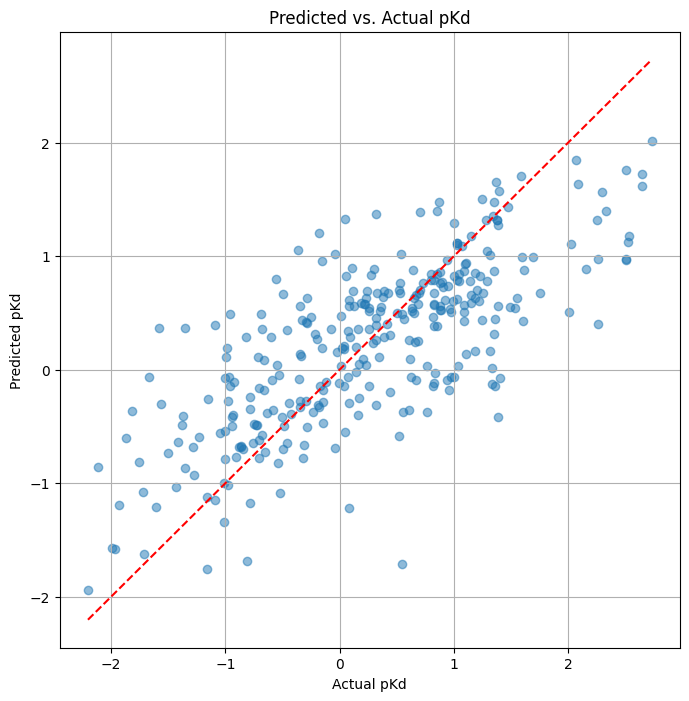

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')